In [1]:
import torch 
import os
import numpy as np
import scipy as sp
import utils
from torch import nn
from torch.nn import functional as F
from torch import optim
from net.chemtools.PLS import PLS
from net.base_net import CuiNet , DeepSpectraCNN, ResNet18_1D , ViT_1D, FullyConvNet
from utils.testing import ccc,r2_score,RMSEP
import matplotlib.pyplot as plt
from utils.training import train
from utils.testing import test
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split


ModuleNotFoundError: No module named 'utils'

In [29]:
data = sp.io.loadmat("/home/metz/deepchemometrics/Aioly/data/dataset/Mango/mango_dm_full_outlier_removed2.mat")
Ycal = data["DM_cal"]
Ytest = data["DM_test"]
Xcal = data["SP_all_train"]
Xtest = data["SP_all_test"]

In [30]:
print("X and Y training set")
print(Ycal.shape)
print(Xcal.shape)

X and Y training set
(9914, 1)
(9914, 618)


In [31]:
print("X and Y testing set")
print(Ytest.shape)
print(Xtest.shape)

X and Y testing set
(1448, 1)
(1448, 618)


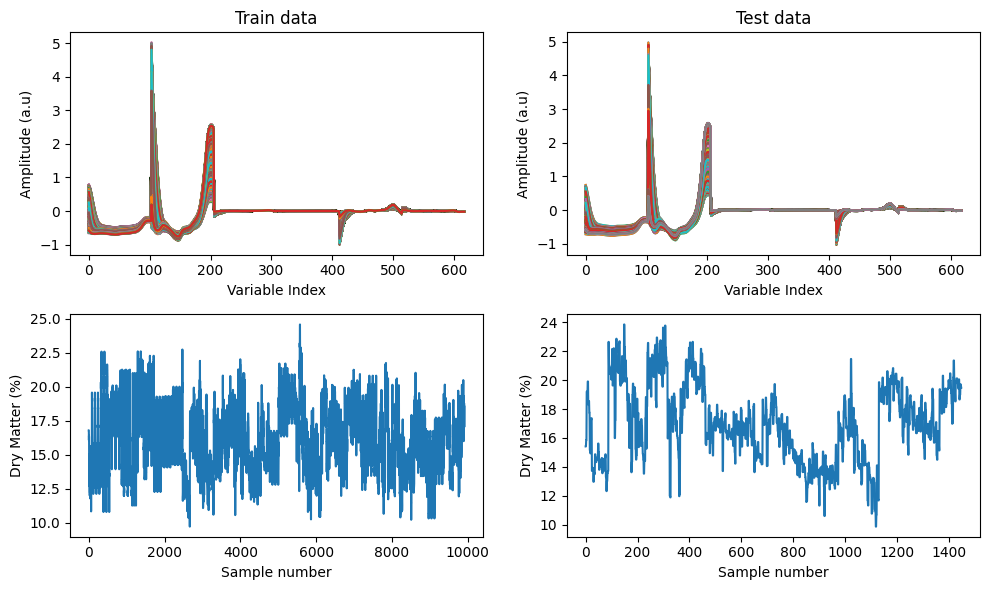

In [32]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.title('Train data')
plt.plot(Xcal.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Variable Index')
plt.subplot(222)
plt.title('Test data')
plt.plot(Xtest.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Variable Index')
plt.subplot(223)
plt.plot(data['DM_cal'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.subplot(224)
plt.plot(data['DM_test'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.tight_layout()
plt.show()

In [33]:
## Spliting the train set 
x_cal, x_val, y_cal, y_val = train_test_split(Xcal, Ycal, test_size=0.20, shuffle=True, random_state=42) 

## The wavelenghts for the XX axis when we plot the spectra
x_scale=data['wave'].astype(np.float32).reshape(-1,1)

## Check for dimensions
print('Data set dimensions ----------------------------')
print('Full Train set dims X Y = {}\t{}'.format(Xcal.shape, Ycal.shape))
print('Calibration set dims X Y = {}\t{}'.format(x_cal.shape, y_cal.shape))
print('val set dims X Y = {}\t{}'.format(x_val.shape, y_val.shape))
print('Test set dims X Y = {}\t{}'.format(Xtest.shape, Ytest.shape))
print('wavelengths number = {}'.format(np.shape(x_scale)))

Data set dimensions ----------------------------
Full Train set dims X Y = (9914, 618)	(9914, 1)
Calibration set dims X Y = (7931, 618)	(7931, 1)
val set dims X Y = (1983, 618)	(1983, 1)
Test set dims X Y = (1448, 618)	(1448, 1)
wavelengths number = (103, 1)


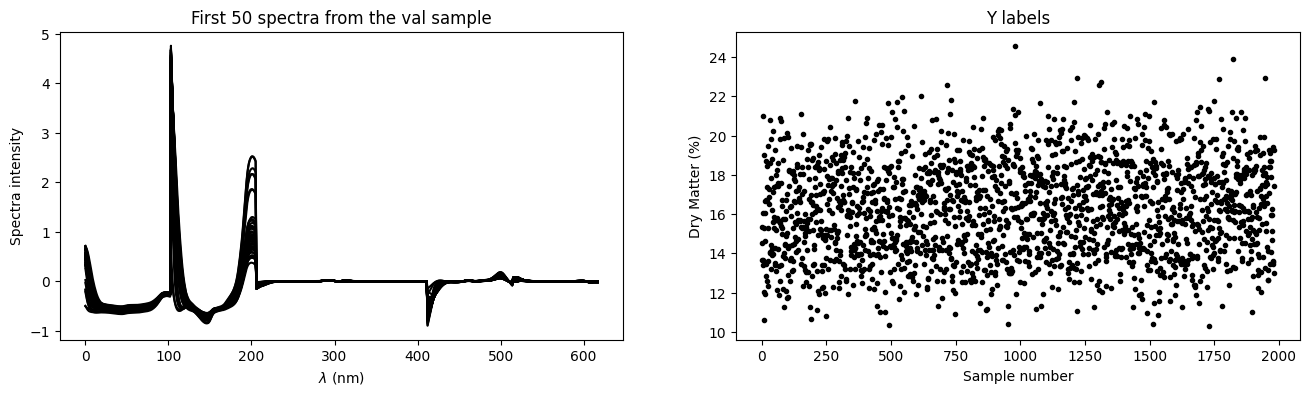

In [34]:
## Visual data sanity checking for the test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(x_val[:50,:].T,'k')
plt.title('First 50 spectra from the val sample')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Spectra intensity')
plt.subplot(1,2,2)
plt.title('Y labels')
plt.plot(y_val,'k.')
plt.xlabel('Sample number')
plt.ylabel('Dry Matter (%)')
plt.show()

In [35]:
# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

# Convert np.array to Dataloader 

cal = data_utils.TensorDataset(torch.Tensor(x_cal), torch.Tensor(y_cal))
cal_loader = data_utils.DataLoader(cal, batch_size=1024, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
val_loader = data_utils.DataLoader(val, batch_size=1024, shuffle=True)

test_dt = data_utils.TensorDataset(torch.Tensor(Xtest), torch.Tensor(Ytest))
test_loader = data_utils.DataLoader(test_dt, batch_size=1024, shuffle=True)


CuiNet(
  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=614, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
)
Epoch 1/1000 | Train Losses: y 0: 121.6702 | Validation Losses: y 0: 15.2124 | R2 Scores: y 0: 0.1135
Epoch 2/1000 | Train Losses: y 0: 28.6387 | Validation Losses: y 0: 8.0750 | R2 Scores: y 0: 0.2732
Epoch 3/1000 | Train Losses: y 0: 18.3048 | Validation Losses: y 0: 3.7975 | R2 Scores: y 0: 0.3260
Epoch 4/1000 | Train Losses: y 0: 14.1329 | Validation Losses: y 0: 3.4136 | R2 Scores: y 0: 0.3210
Epoch 5/1000 | Train Losses: y 0: 11.7513 | Validation Losses: y 0: 2.1796 | R2 Scores: y 0: 0.3476
Epoch 6/1000 | Train Losses: y 0: 10.0139 | Validation Losses: y 0: 1.9322 | R2 Scores: y 0: 0.3907
Epoch 7/1000 | Train Losses: y 0: 9.1295 | Validation Losses: y 0: 1.4756 | R2 Scores: y 0: 

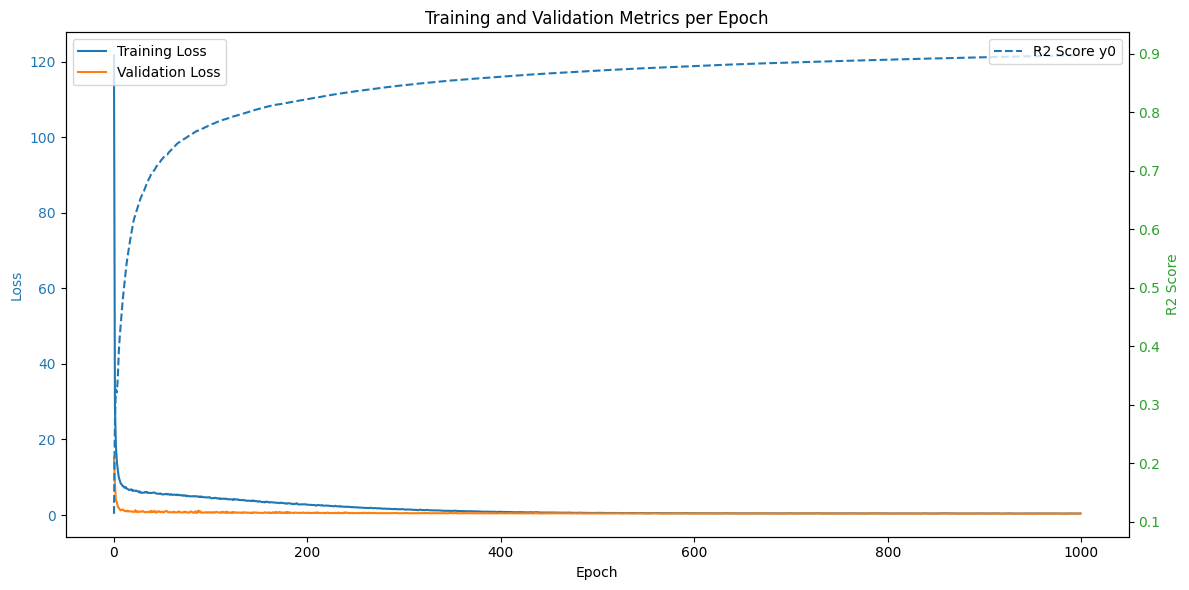

In [36]:
# define model parameters 

model_name ="_CuiNet_Mango"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 1000
save_interval = 10
data_path ="/home/metz/deepchemometrics/Aioly/data/dataset/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = CuiNet(spec_dims, mean = mean,std = std, out_dims=1) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval)

CCC: 0.93291, R2: 0.84023, RMSEP: 0.90791


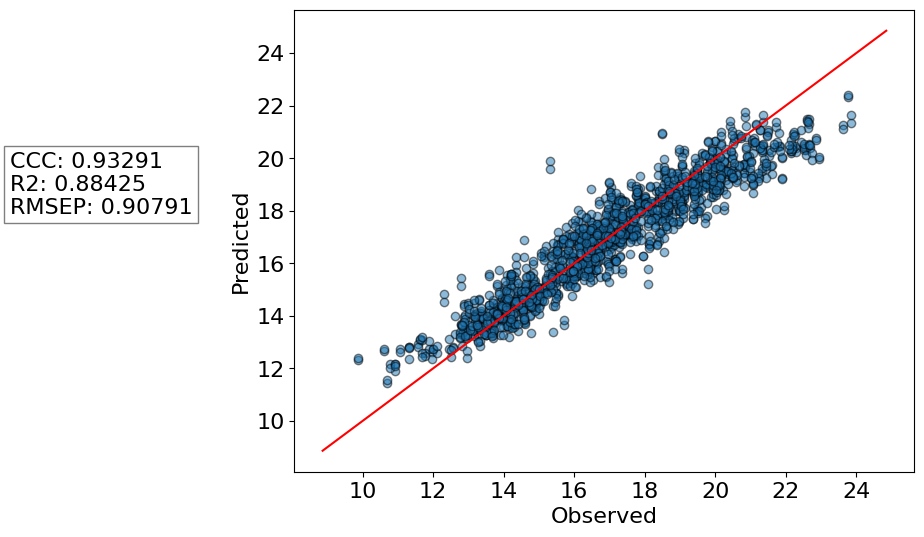

In [37]:

utils.test(model,final_path,test_loader)

DeepSpectraCNN(
  (conv1): Conv1d(1, 8, kernel_size=(7,), stride=(3,), padding=(3,))
  (inception2): InceptionModule(
    (branch1): ConvBlock1D(
      (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
      (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (branch2): Sequential(
      (0): ConvBlock1D(
        (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
        (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): ConvBlock1D(
        (conv1d): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (branch3): Sequential(
      (0): ConvBlock1D(
        (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
        (batchnorm1d)

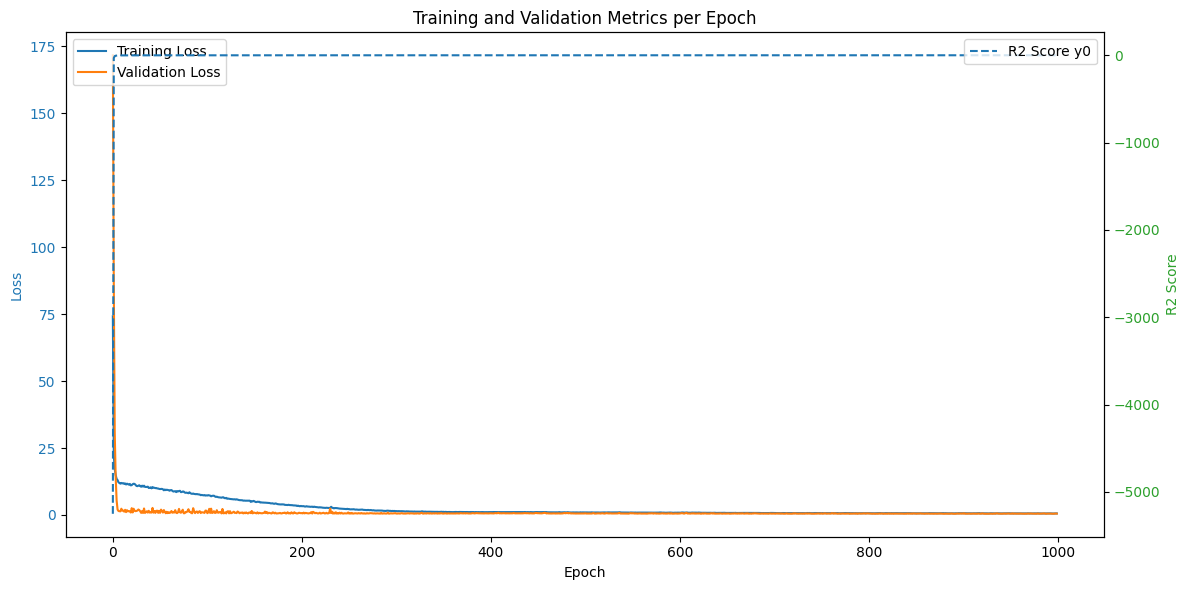

In [38]:
model_name ="_DeepSpectra_Mango_"  
LR = 0.01
num_epochs = 1000
save_interval = 10
data_path ="/home/metz/deepchemometrics/Aioly/data/dataset/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = DeepSpectraCNN(spec_dims, mean = mean,std = std, out_dims=1) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval)


CCC: 0.89528, R2: 0.73523, RMSEP: 1.12051


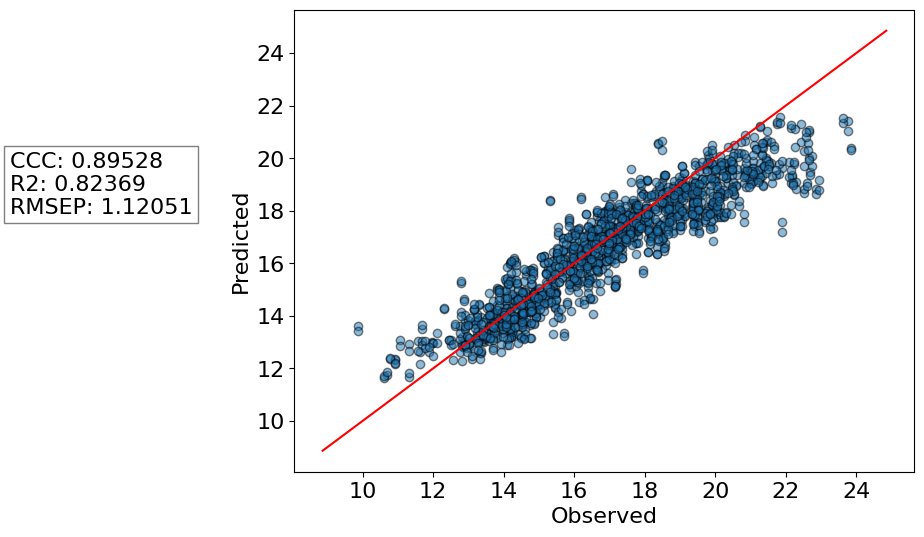

In [39]:
utils.test(model,final_path,test_loader)

ResNet1D(
  (conv1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, 

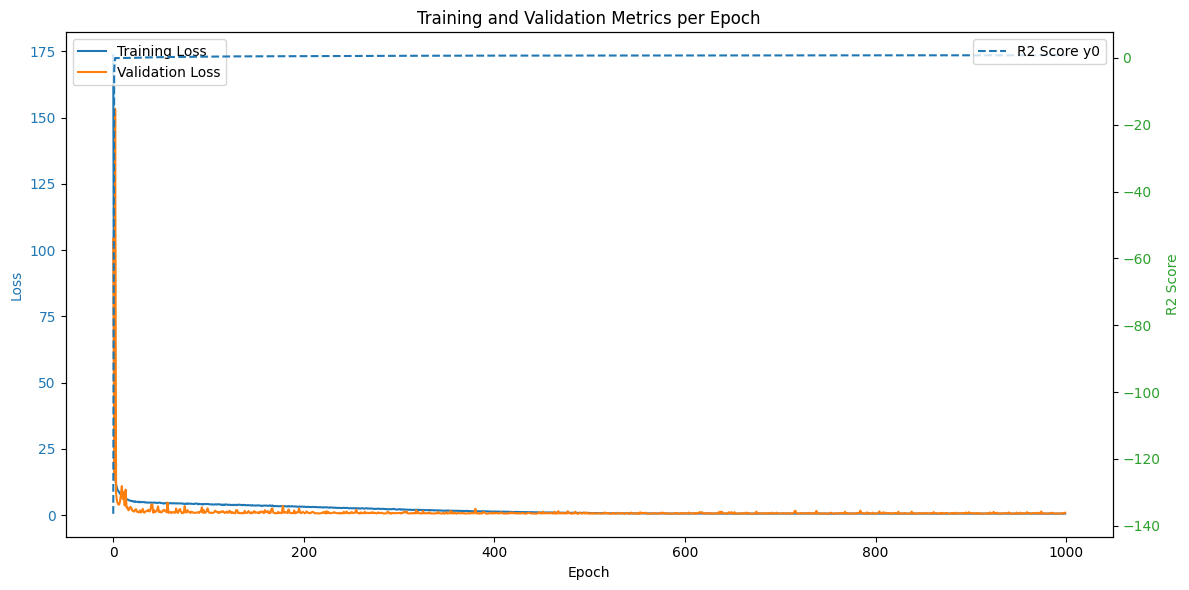

In [40]:

model_name ="_ResNET18_Mango_"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 1000
save_interval = 10
data_path ="/home/metz/deepchemometrics/Aioly/data/dataset/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = ResNet18_1D(mean = mean,std = std, out_dims=1) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval)

CCC: 0.82269, R2: 0.45871, RMSEP: 1.40691


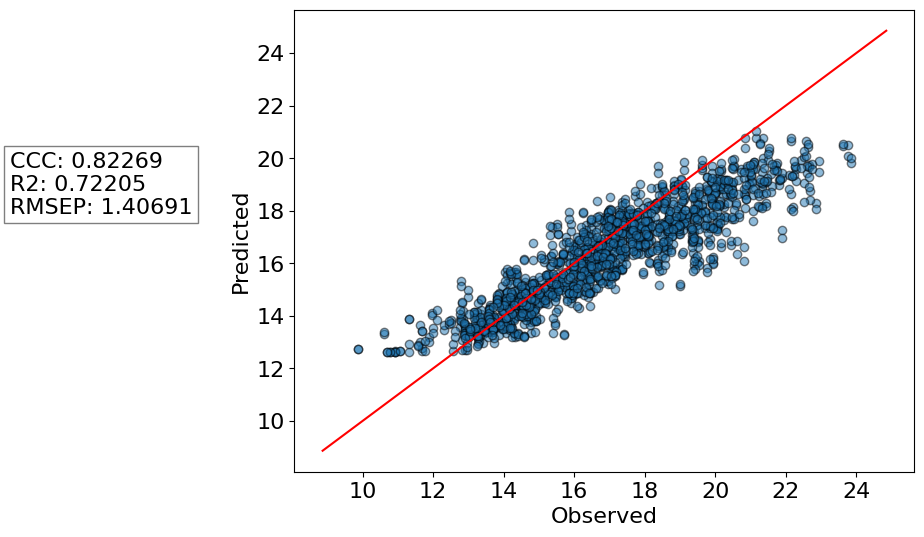

In [41]:
utils.test(model, final_path, test_loader)

ViT_1D(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (n p) -> b n (p c)', p=10)
    (1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=10, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-7): 8 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.5, inplace=False)
          (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=512, out_features=64, bias=True)
            (1): Dropout(p=0.5, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=64

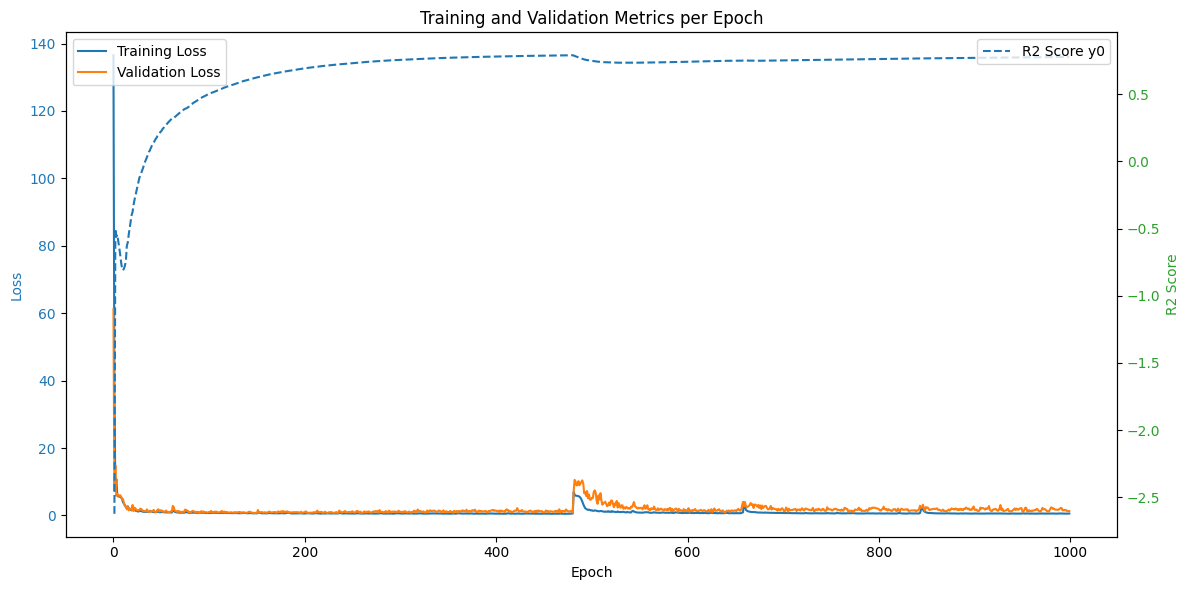

In [42]:

model_name ="_ViT_1D_Mango_"  
spec_dims = x_cal.shape[1]
LR = 0.01
num_epochs = 1000
save_interval = 10
data_path ="/home/metz/deepchemometrics/Aioly/data/dataset/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = ViT_1D(mean = mean,std = std, seq_len = spec_dims, patch_size = 10, dim_embed = 64, trans_layers = 8, heads = 8, mlp_dim = 64, out_dims =1, dropout=0.5) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval)

CCC: 0.89828, R2: 0.81840, RMSEP: 1.28873


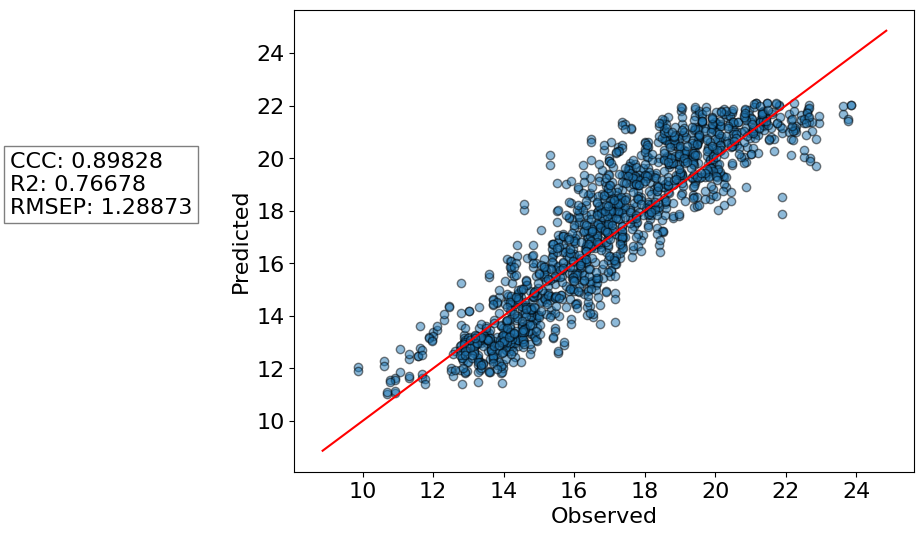

In [43]:
utils.test(model, final_path, test_loader)

FullyConvNet(
  (conv1d_1): Conv1d(1, 2, kernel_size=(9,), stride=(1,))
  (avg_1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv1d_2): Conv1d(2, 2, kernel_size=(7,), stride=(1,))
  (avg_2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv1d_3): Conv1d(2, 4, kernel_size=(7,), stride=(1,))
  (avg_3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv1d_4): Conv1d(4, 8, kernel_size=(5,), stride=(1,))
  (avg_4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv1d_5): Conv1d(8, 12, kernel_size=(3,), stride=(1,))
  (dp): Dropout(p=0.5, inplace=False)
  (head): Conv1d(12, 1, kernel_size=(1,), stride=(1,))
)
Epoch 1/1000 | Train Losses: y 0: 270.6448 | Validation Losses: y 0: 273.3831 | R2 Scores: y 0: 35528290304.0000
Epoch 2/1000 | Train Losses: y 0: 269.2913 | Validation Losses: y 0: 271.9968 | R2 Scores: y 0: -606202.5625
Epoch 3/1000 | Train Losses: y 0: 267.8298 | Validation Losses: y 0: 270.3736 | R2 Scores: y 0: -191405.3125
Epoch

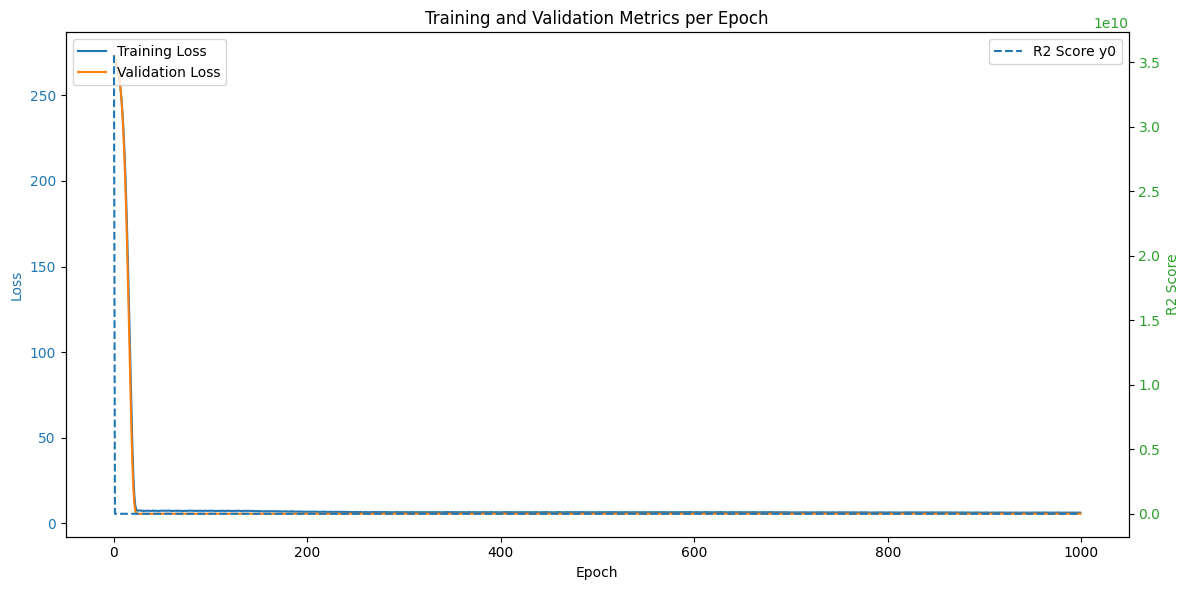

In [44]:
model_name ="_FullyConvNet_OSSL_"
spec_dims = x_cal.shape[1]
LR = 0.001
num_epochs = 1000
save_interval = 10
data_path ="/home/metz/deepchemometrics/Aioly/data/dataset/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = FullyConvNet(spec_dims, mean = mean,std = std,out_dims=1)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')
print(model)

train_losses, val_losses,val_r2_scores, final_path =train(model, optimizer, criterion, cal_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval)


CCC:   nan, R2: -548054532299.93164, RMSEP: 2.82405


/home/metz/Env_virt/pytorch/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/metz/Env_virt/pytorch/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/metz/Env_virt/pytorch/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/metz/Env_virt/pytorch/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


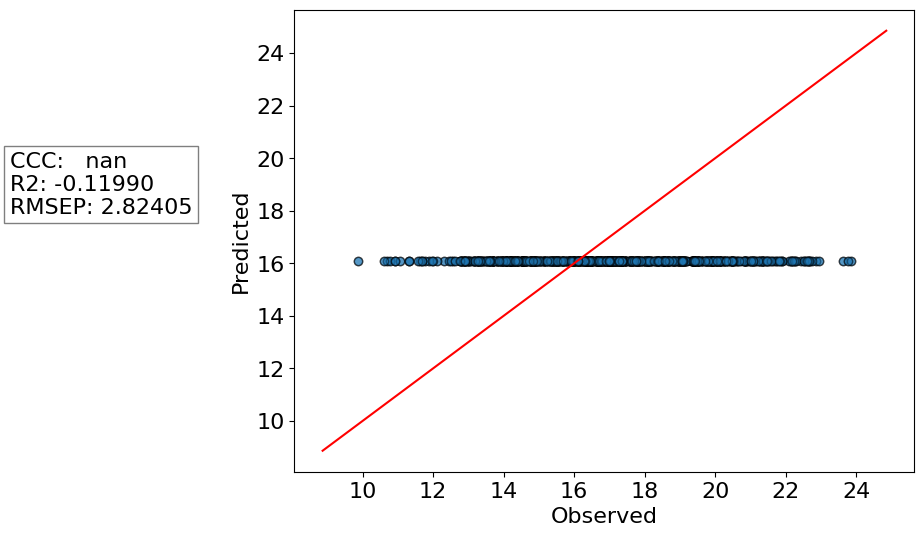

In [45]:
utils.test(model, final_path, test_loader)

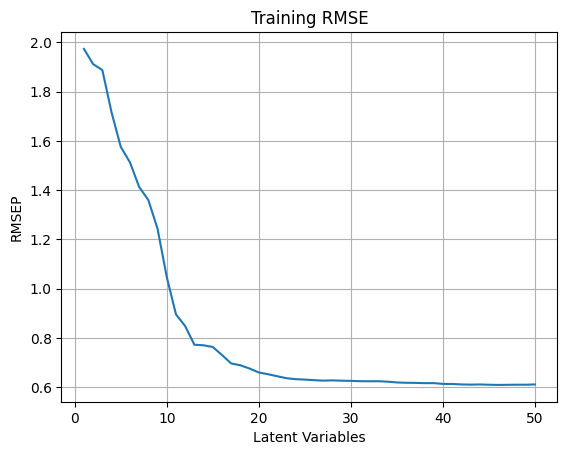

In [46]:
# PLS model test 
ncomp=50
pls =PLS(ncomp=ncomp)
pls.fit(x_cal, y_cal)

perf = []
for lv in range(ncomp):
    y_pred = pls.predict(x_val, lv)
    rmse = torch.sqrt(F.mse_loss(y_pred, torch.Tensor(y_val), reduction='none')).mean(dim=0)
    perf.append(rmse)
    
fig=plt.figure()
plt.plot(range(1, ncomp + 1), [p.item() for p in perf] )
plt.xlabel('Latent Variables')
plt.ylabel('RMSEP')
plt.title(f'Training RMSE')
plt.grid(True)
plt.show()

/tmp/ipykernel_258533/292610370.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("CCC: %5.5f, R2: %5.5f, RMSEP: %5.5f"%(ccc(y_pred,Ytest), r2_score(y_pred, Ytest), RMSEP(y_pred, Ytest)))
/tmp/ipykernel_258533/292610370.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(0, 0.75*Ytest.max(), "CCC: %5.5f"%(ccc(Ytest,y_pred))+"\nR2: %5.5f"%(r2_score(Ytest,y_pred))+"\nRMSEP: %5.5f"%(RMSEP(Ytest,y_pred)),


CCC: 0.91316, R2: 0.79941, RMSEP: 1.04670


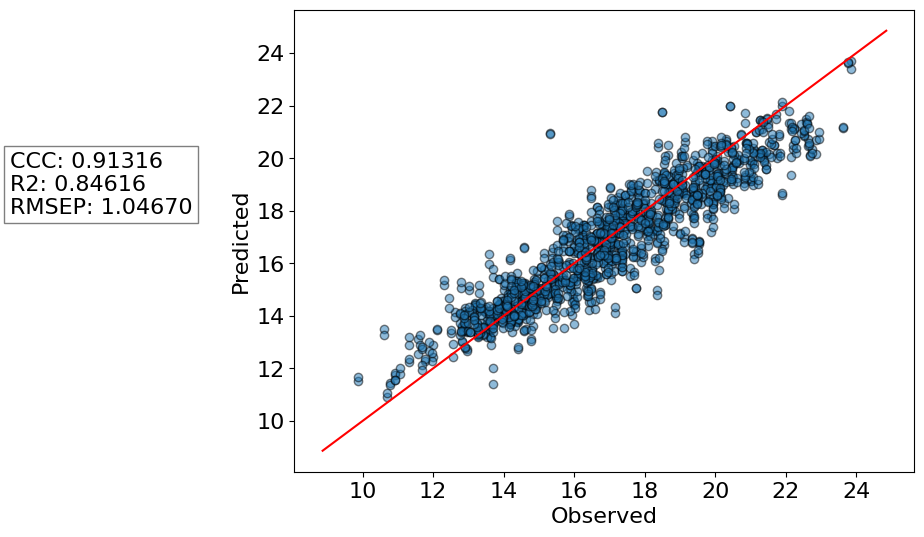

In [50]:
y_pred = pls.predict(Xtest, 20)
rmse = torch.sqrt(F.mse_loss(y_pred, torch.Tensor(Ytest), reduction='none')).mean(dim=0)
y_pred = np.array(y_pred)
print("CCC: %5.5f, R2: %5.5f, RMSEP: %5.5f"%(ccc(y_pred,Ytest), r2_score(y_pred, Ytest), RMSEP(y_pred, Ytest)))

plt.figure(figsize=(8,6))

# Scatter plot of X vs Y
plt.scatter(Ytest,y_pred,edgecolors='k',alpha=0.5)

# Plot of the 45 degree line
plt.plot([Ytest.min()-1,Ytest.max()+1],[Ytest.min()-1,Ytest.max()+1],'r')
  
plt.text(0, 0.75*Ytest.max(), "CCC: %5.5f"%(ccc(Ytest,y_pred))+"\nR2: %5.5f"%(r2_score(Ytest,y_pred))+"\nRMSEP: %5.5f"%(RMSEP(Ytest,y_pred)),
         fontsize=16, bbox=dict(facecolor='white', alpha=0.5))


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Observed',fontsize=16)
plt.ylabel('Predicted',fontsize=16)

plt.show(block=False)
